## Package loading

In [1]:
source("../src/functions.R")

── Attaching packages ────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR

# Data loading

In [2]:
count <- read_delim("../data/count.txt.gz", delim="\t")
expdesign <- read_delim("../data/expdesign.txt.gz", delim="\t", skip=6)


── Column specification ───────────────────────────────────────────────
cols(
  .default = col_double(),
  gene_name = col_character()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ───────────────────────────────────────────────
cols(
  index = col_double(),
  sequencing_batch = col_double(),
  amplification_batch = col_double(),
  mouse_ID = col_logical(),
  pool_barcode = col_character(),
  sample_barcode = col_character(),
  plate_id = col_double(),
  well_id = col_character(),
  number_of_cells = col_character(),
  sorting_markers = col_character(),
  RMT_length = col_double(),
  group_name = col_character(),
  ERCC_dilution = col_double(),
  ERCC_volume_ul = col_double(),
  Column_name_in_processed_data_file = col_character()
)


Warning message:
“3072 parsing failures.
 row      col           expected actual                       file
1527 mouse_ID 1/0/T/F/TRUE/FALSE      4 '../data/expdesign.txt.gz'
1528 mouse_ID 1/0/T/F/TRUE/FALSE      4 '../d

# Wide -> Long

In [3]:
count %>%
	pivot_longer(-gene_name, names_to="cell", values_to="exp") %>%
		inner_join(expdesign,
			by=c("cell"="Column_name_in_processed_data_file")) %>%
			rename_all(tolower) %>%
				group_by(cell) %>%
					mutate(sum=sum(exp)) %>%
							filter(sum != 0 &&
								number_of_cells == 1 &&
								group_name %in%
									c("B cell", "CD8+pDC",
										"monocyte_or_neutrophil", "NK_cell")) %>%
									ungroup %>%
										arrange(cell) -> marsdata

# Long -> Wide

In [4]:
# Extract gene expression part
marsdata %>%
	select(gene_name, cell, exp) %>%
		pivot_wider(names_from="cell", values_from="exp") -> wide_marsdata

# Gene name
wide_marsdata %>%
	select(gene_name) %>%
		data.frame %>%
			.[,1] -> genename

# Expression matrix -> SingleCellExperiment
wide_marsdata %>%
	select(!gene_name) %>%
		as.matrix %>%
			SingleCellExperiment(assays=list(counts=.[])) -> sce_marsdata

# rownames
genename -> rownames(sce_marsdata)

# coldata
marsdata %>%
	select(!c(gene_name, exp)) %>%
		distinct %>%
			arrange(cell) %>%
				DataFrame -> colData(sce_marsdata)

# scater

In [5]:
# Analysis workflow of scater
sce_marsdata %>%
	logNormCounts %>%
		runPCA(ntop=2000, ncomponents=10) %>%
			runTSNE(dimred = "PCA") %>%
				runUMAP(dimred = "PCA") -> sce_marsdata
# save
save(sce_marsdata, file="../results/mars.RData")

# Visualization

## Standard plot functions of R

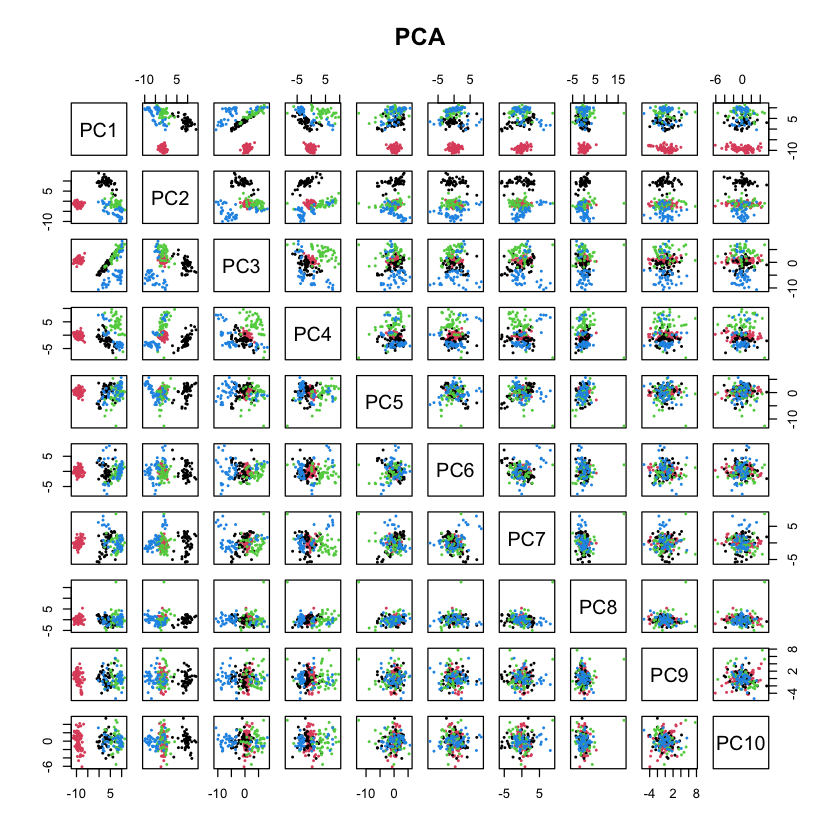

In [6]:
pairs(reducedDim(sce_marsdata, "PCA"),
	col=factor(colData(sce_marsdata)$group_name),
	pch=16, cex=0.5, main="PCA")

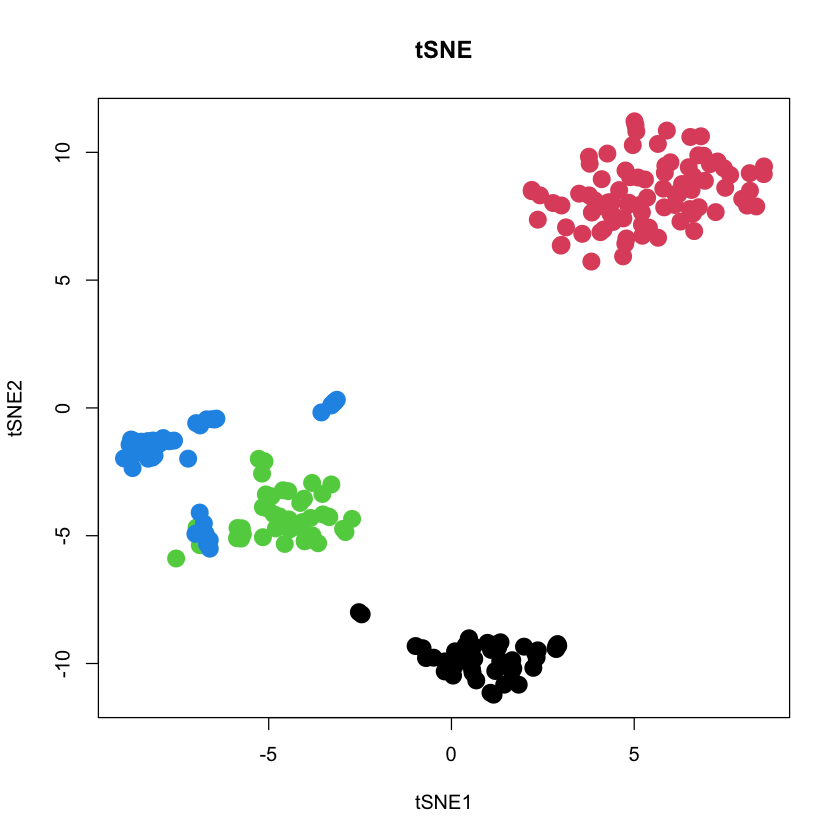

In [7]:
plot(reducedDim(sce_marsdata, "TSNE"),
	col=factor(colData(sce_marsdata)$group_name),
	xlab="tSNE1", ylab="tSNE2",
	pch=16, cex=2, main="tSNE")

## Pair/scatter plot (scater)

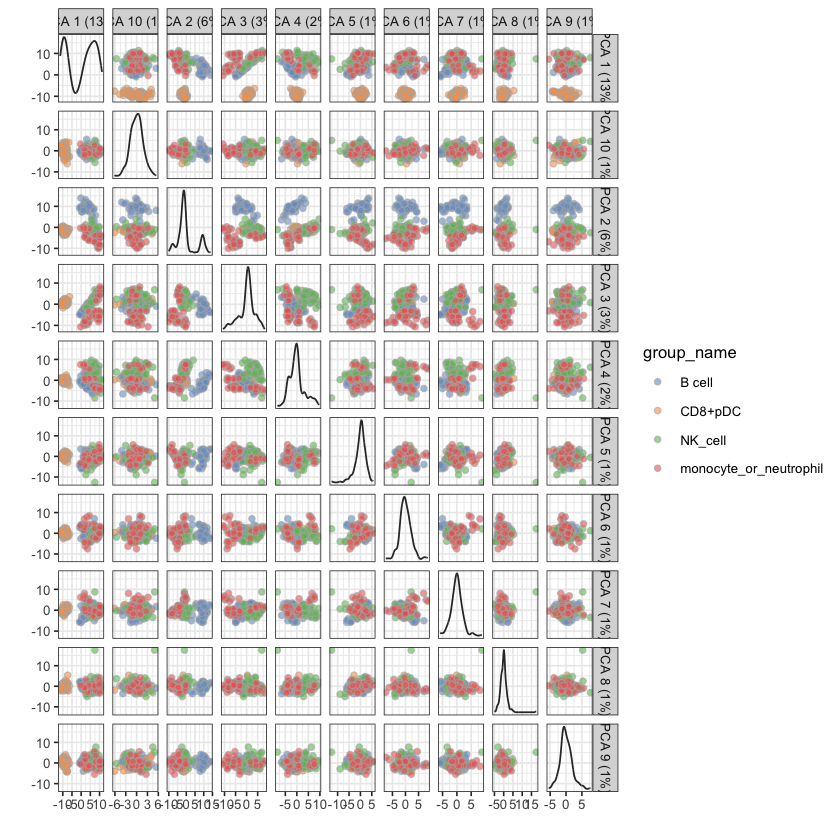

In [8]:
sce_marsdata %>%
	plotReducedDim(dimred="PCA", colour_by="group_name", ncomponents=10)

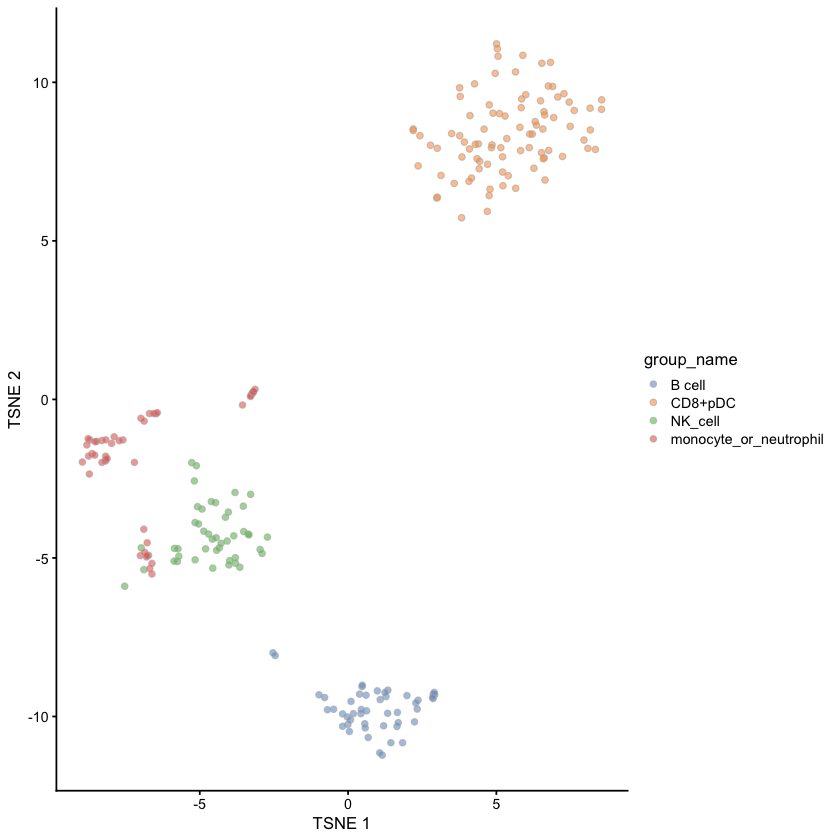

In [9]:
sce_marsdata %>%
	plotReducedDim(dimred="TSNE", colour_by="group_name")

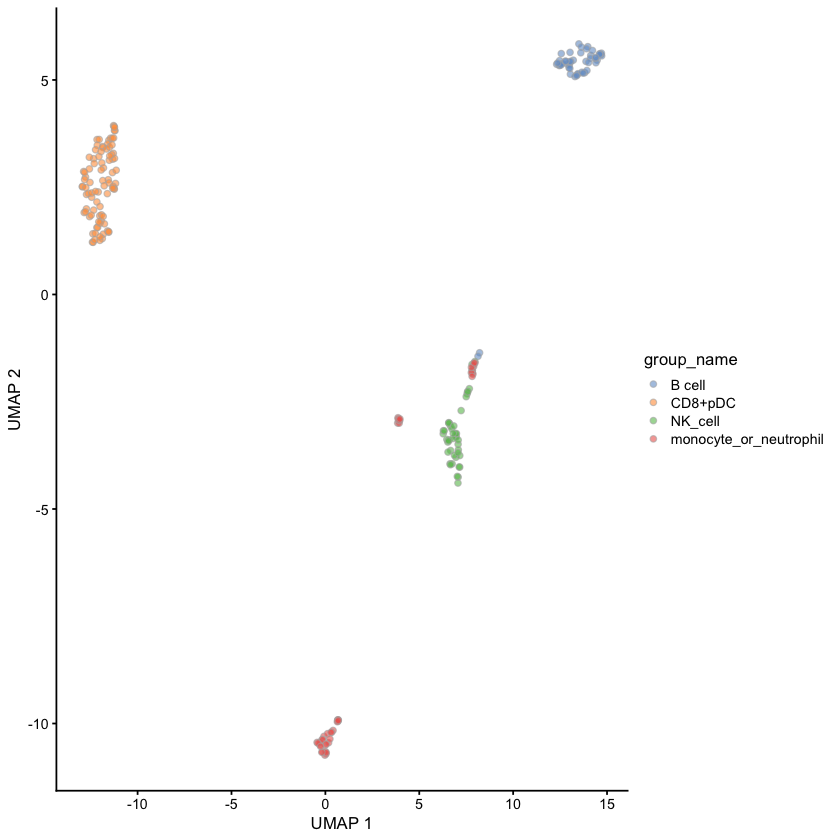

In [10]:
sce_marsdata %>%
	plotReducedDim(dimred="UMAP", colour_by="group_name")

## Scatter plot (schex)

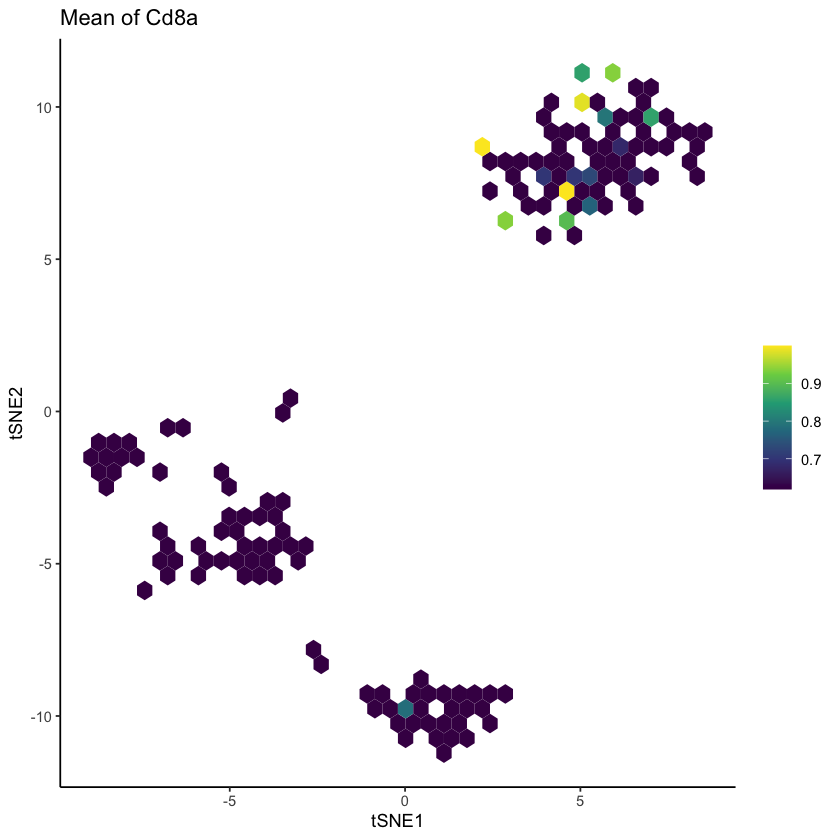

In [11]:
sce_marsdata %>%
	make_hexbin(nbins=40, dimension_reduction="TSNE") %>%
		plot_hexbin_feature(feature="Cd8a", type="logcounts",
			action="mean", xlab="tSNE1", ylab="tSNE2",
			title=paste0("Mean of Cd8a"))

## ggplot2

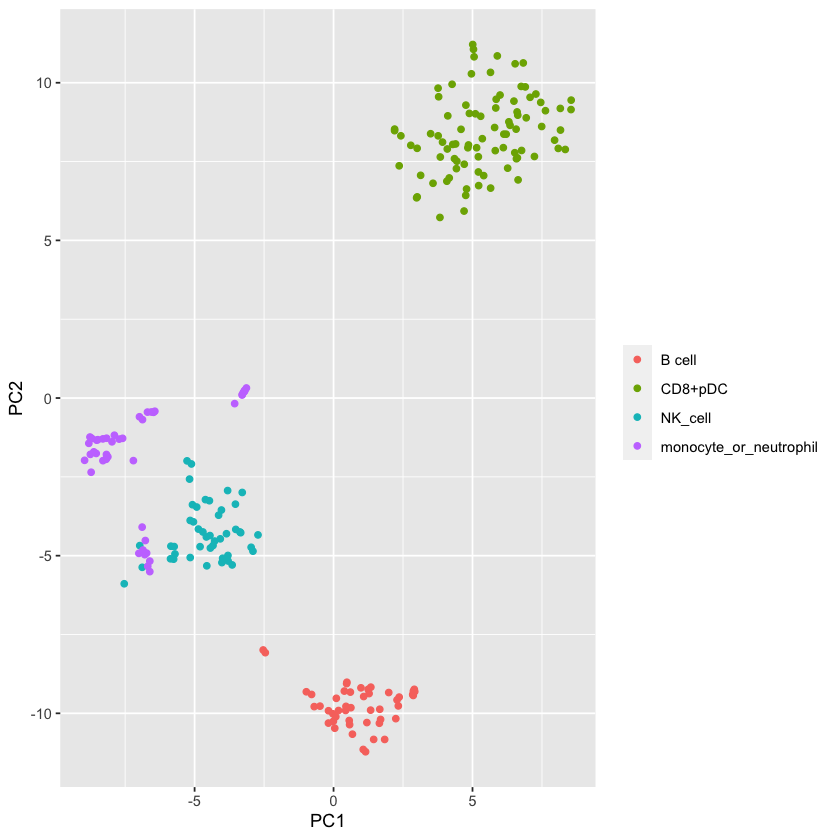

In [12]:
reducedDim(sce_marsdata, "TSNE") %>%
	cbind(colData(sce_marsdata)$group_name) %>%
		data.frame %>%
			mutate_at(vars(-X3), as.numeric) %>%
			ggplot(aes(x=X1, y=X2, color=X3)) +
				geom_point() +
					xlab("PC1") +
						ylab("PC2") +
							theme(legend.title = element_blank())

## ggpairs

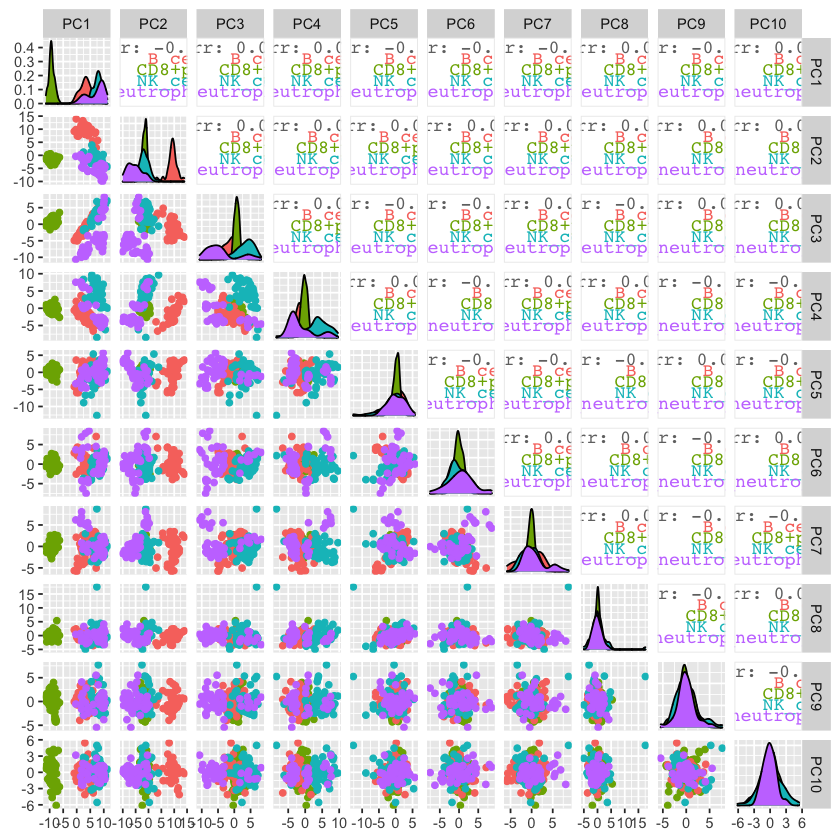

In [13]:
reducedDim(sce_marsdata, "PCA") %>%
	cbind(colData(sce_marsdata)$group_name) %>%
		data.frame %>%
			mutate_at(vars(-V11), as.numeric) %>%
			ggpairs(columns=1:10, aes(color=V11))

## pairsD3

In [14]:
# reducedDim(sce_marsdata, "PCA") %>%
# 	.[,1:5] %>%
# 		pairsD3(group=colData(sce_marsdata)$group_name,
# 			tooltip=colData(sce_marsdata)$cell)

## Plotly

In [15]:
# reducedDim(sce_marsdata) %>%
# 	as_tibble %>%
# 		select(PC1, PC2, PC8) %>%
# 			data.frame %>%
# 				plot_ly(x=~PC1, y=~PC2, z=~PC8,
# 			    type = "scatter3d", mode = "markers",
# 			    text = colData(sce_marsdata)$cell,
# 			    color =~colData(sce_marsdata)$group_name
# 			    )

## iSEE

In [16]:
# app <- iSEE(sce_marsdata)
# runApp(app)

# Session Information

In [17]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS/LAPACK: /Users/tsuyusakikouki/opt/anaconda3/envs/r-4.0/lib/libopenblasp-r0.3.10.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] schex_1.2.0                 Seurat_3.2.2               
 [3] ggbeeswarm_0.6.0            styler_1.3.2               
 [5] formatR_1.7                 lintr_2.0.1                
 [7] knitr_1.30                  BiocStyle_2.16.0           
 [9] rmarkdown_2.5               pairsD3_0.1.0              
[11] shiny_1.5.0                 iSEE_2.0.0                 
[13] plotly_4.9.2.1              GGally_2.0.0               
[15] scater_1.16.0               SingleCellExperiment_1.10.1
[17] SummarizedExperiment_1.18.1 DelayedArray_0.14.0        
[19] matrixStats_0.57.0          Biobase_2.4